# Churn prediction 

In the prior analysis, the Olist customers were segmented and their customer life time value was calculated. This enables Olist to identify their best customers. If these customers were to leave Olist and become a customer in one of Olist competitors then it would hurt Olist revenue. Therefore, it is relevant to conduct a churn analysis in order to identify which customers might churn in the future. Knowing this, Olist can take actions specifik againt the customer likely to churn to keep the customer.



In the following notebook a churn analysis will be carried out. The churn analysis employs survival analysis to predict whether a customer will churn or not. Survival analysis has been chosen because besides giving an idea if a customer is going to stop doing business it also gives a probability for when the event might happen. 







In [70]:
# Standard packages are imported
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
warnings.filterwarnings('ignore')
%matplotlib inline

dirpath = '../data/'

The customer data sets are loaded as in the previous notebook which include Olist_customers,Olist_orders and Olist_order_payments. Futhermore, the order item dataset is joined with the customer data since it could be relevant to use features such as product category for later modelling in the prediction model.

In [71]:
# Load data
customers = pd.read_csv(dirpath+"olist_customers_dataset.csv")
order_payments = pd.read_csv(dirpath+"olist_order_payments_dataset.csv")
orders = pd.read_csv(dirpath+"olist_orders_dataset.csv")
orders_item = pd.read_csv(dirpath+"olist_order_items_dataset.csv")
products = pd.read_csv(dirpath+"olist_products_dataset.csv")

# Join
customer_order = customers.merge(orders, on='customer_id', how='left')
order_payments = order_payments.groupby('order_id').sum().reset_index()[['order_id','payment_value']]
cop = customer_order.merge(order_payments, on='order_id', how='left')
cop = cop.merge(orders_item, on='order_id', how='left')
cop = cop.merge(products, on='product_id', how='left')

# clean and format
cop['order_purchase_timestamp'] = pd.to_datetime(cop['order_purchase_timestamp'])
cop = cop[cop['order_status']!='canceled']

The dataset is viewed below

In [73]:
cop.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,...,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,...,124.99,21.88,moveis_escritorio,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,...,289.00,46.48,utilidades_domesticas,43.0,1002.0,3.0,10150.0,89.0,15.0,40.0
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,...,139.94,17.79,moveis_escritorio,55.0,955.0,1.0,8267.0,52.0,52.0,17.0
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,...,149.94,23.36,moveis_escritorio,48.0,1066.0,1.0,12160.0,56.0,51.0,28.0
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,...,230.00,22.25,casa_conforto,61.0,407.0,1.0,5200.0,45.0,15.0,35.0


In [74]:
cop.describe()

,customer_zip_code_prefix,payment_value,order_item_id,price,freight_value,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
count,112719.000000,112716.000000,112108.000000,112108.000000,112108.000000,110519.000000,110519.000000,110519.000000,112090.000000,112090.000000,112090.000000,112090.000000
mean,35141.802340,179.954597,1.197345,120.387559,19.991964,48.789041,787.913110,2.210579,2093.544170,30.154456,16.584459,22.994710
std,29869.770239,271.736749,0.704291,182.661658,15.797391,10.018171,651.974693,1.722197,3751.282204,16.152807,13.435400,11.700754
min,1003.000000,9.590000,1.000000,0.850000,0.000000,5.000000,4.000000,1.000000,0.000000,7.000000,2.000000,6.000000
25%,11320.000000,65.647500,1.000000,39.900000,13.080000,42.000000,348.000000,1.000000,300.000000,18.000000,8.000000,15.000000
50%,24342.000000,114.350000,1.000000,74.940000,16.270000,52.000000,603.000000,1.000000,700.000000,25.000000,13.000000,20.000000
75%,59056.000000,195.012500,1.000000,134.900000,21.150000,57.000000,987.000000,3.000000,1800.000000,38.000000,20.000000,30.000000
max,99990.000000,13664.080000,21.000000,6735.000000,409.680000,76.000000,3992.000000,20.000000,40425.000000,105.000000,105.000000,118.000000


In [75]:
cop.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112719 entries, 0 to 113424
Data columns (total 27 columns):
customer_id                      112719 non-null object
customer_unique_id               112719 non-null object
customer_zip_code_prefix         112719 non-null int64
customer_city                    112719 non-null object
customer_state                   112719 non-null object
order_id                         112719 non-null object
order_status                     112719 non-null object
order_purchase_timestamp         112719 non-null datetime64[ns]
order_approved_at                112699 non-null object
order_delivered_carrier_date     111381 non-null object
order_delivered_customer_date    110189 non-null object
order_estimated_delivery_date    112719 non-null object
payment_value                    112716 non-null float64
order_item_id                    112108 non-null float64
product_id                       112108 non-null object
seller_id                        112108 

## Data preparation for survival analysis

In survival analysis, a data point is characterised by three elements: $X_i,E_i,T_i, \forall i \in N$ where $N$ is number of datapoints. 

- $X_i$ : is a p-dimensional feature vector
- $E_i$ : is an event indicator. If $E_i = 1$ an event happens, the other case where $E_i=0$ means that the data point is censored because an event does not happen. 
- $T_i$ : $min(t_i,c_i)$ , where $t_i$ is the actual time to event and $c_i$ is time to censoring


In the following section, the data will be preprocessed to be ready for modelling with survival models:

1. An Event-column will be calculated
2. 

In [47]:
test = cop.merge(cop.groupby('customer_unique_id').size().reset_index(), on='customer_unique_id', how='left')
test1 = test[test.iloc[:,-1] > 1]

In [48]:
test1 = test1.groupby('customer_unique_id')['order_purchase_timestamp'].apply(lambda x: x.sort_values()).reset_index()
test1['T'] = (test1.groupby('customer_unique_id')['order_purchase_timestamp'].diff() / np.timedelta64(1, 'W'))
test1 = test1.dropna(subset=['T'])
test1['T'] = test1['T'].apply(np.ceil).astype(int)
test1 = test1[test1['T'] > 0]
test1['E'] = 1
test1 = test1[['customer_unique_id', 'order_purchase_timestamp','T','E']]

In [49]:
t_end = cop.order_purchase_timestamp.max()
test2 = test[test.iloc[:,-1] < 2]
test2['E'] = 0
test2['T'] = ((t_end - test2.order_purchase_timestamp) / np.timedelta64(1, 'W')).apply(np.ceil).astype(int)
test2 = test2[['customer_unique_id', 'order_purchase_timestamp','T','E']]

In [58]:
test2 = test2[:16000]

In [59]:
test_df = pd.concat([test1,test2])
df_full = test_df.merge(cop, on=['customer_unique_id','order_purchase_timestamp'], how='left')

df_model = df_full[['T','E','customer_state','payment_value']]
df_model = pd.get_dummies(data=df_model, columns=['customer_state'])

In [60]:
df_full.head()

,customer_unique_id,order_purchase_timestamp,T,E,customer_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,...,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,004288347e5e88a27ded2bb23747066c,2018-01-14 07:36:54,25,1,f6efe5d5c7b85e12355f9d5c3db46da2,26220,nova iguacu,RJ,08204559bebd39e09ee52dcb56d8faa2,delivered,...,87.90,15.38,malas_acessorios,39.0,278.0,1.0,700.0,19.0,48.0,35.0
1,004b45ec5c64187465168251cd1c9c2f,2018-05-26 19:42:48,39,1,d95f60d70d9ea9a7fe37c53c931940bb,57035,maceio,AL,9392c5e72885ad5aba87e6223ca9838d,delivered,...,27.00,22.85,moveis_decoracao,45.0,660.0,1.0,3450.0,23.0,35.0,35.0
2,00a39521eb40f7012db50455bf083460,2018-06-03 10:12:57,2,1,cbb68c721ba9ddb30d8a490cc1897fa1,72595,brasilia,DF,cea3e6c11eb60acb9d8d4d51694832f8,delivered,...,11.55,15.23,eletronicos,45.0,868.0,1.0,175.0,22.0,12.0,15.0
3,00cc12a6d8b578b8ebd21ea4e2ae8b27,2017-03-21 19:25:23,1,1,102fc0966044243157bb81e4ee0a251e,3178,sao paulo,SP,d61b915b69851aec8a8865f36cfd793e,delivered,...,69.90,11.88,cama_mesa_banho,52.0,534.0,1.0,700.0,45.0,15.0,35.0
4,011575986092c30523ecb71ff10cb473,2018-04-18 21:58:08,9,1,71c7265705afd84d030d6adc3122d8dd,30660,belo horizonte,MG,ed0a6265b5b0a292cd537214f401f1fc,delivered,...,63.90,16.42,instrumentos_musicais,58.0,767.0,8.0,500.0,30.0,15.0,30.0


The distribution of the customers who churned/not-churned are shown below.

In [61]:
df_full.E.value_counts()

0    4000
1    3623
Name: E, dtype: int64

In [62]:
#count of how many times each product category has been bought
df_full.product_category_name.value_counts()

cama_mesa_banho                                  903
beleza_saude                                     649
esporte_lazer                                    637
moveis_decoracao                                 583
informatica_acessorios                           540
utilidades_domesticas                            466
relogios_presentes                               409
automotivo                                       285
telefonia                                        267
brinquedos                                       257
ferramentas_jardim                               245
perfumaria                                       225
cool_stuff                                       221
fashion_bolsas_e_acessorios                      196
bebes                                            191
papelaria                                        145
eletronicos                                      140
pet_shop                                         118
moveis_escritorio                             

The data is checked for Null values and and duplicates

In [66]:
N_null = sum(df_model.iloc[:,2:].isnull().sum())
N_dupli = sum(df_model.iloc[:,2:].duplicated(keep='first'))
print('The raw_dataset contains {} null values.'.format(N_null))
print('The dataset contains {} duplicates.'.format(N_dupli))

The raw_dataset contains 0 null values.
The dataset contains 1559 duplicates.


As a final step in the data preparation, the data is standardised by subtracting the mean and dividing with the std.

In [67]:
mu = df_model.payment_value.mean()
sigma = df_model.payment_value.std()
df_model.payment_value = (df_model.payment_value - mu)/sigma # standardization of data
df_model = df_model.dropna()

It is relevant to see the correlation between the chosen features. This can be done through pysurvivals correlation_matrix function.

In [69]:
from pysurvival.utils.display import correlation_matrix
correlation_matrix(df_model.iloc[:,2:], figure_size=(30, 15), text_fontsize=10)

ImportError: dlopen(//anaconda3/lib/python3.7/site-packages/pysurvival/models/_non_parametric.cpython-37m-darwin.so, 2): Symbol not found: __ZNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEE9_M_assignERKS4_
  Referenced from: //anaconda3/lib/python3.7/site-packages/pysurvival/models/_non_parametric.cpython-37m-darwin.so
  Expected in: /usr/lib/libstdc++.6.dylib
 in //anaconda3/lib/python3.7/site-packages/pysurvival/models/_non_parametric.cpython-37m-darwin.so

## Modelling

The data is splitted into a train and test set.

In [ ]:
from sklearn.model_selection import train_test_split
time_column = 'T'
event_column = 'E'

N = df_model.shape[0]

index_train, index_test = train_test_split( range(N), test_size = 0.35)
data_train = df_model.loc[index_train].reset_index( drop = True )
data_test  = df_model.loc[index_test].reset_index( drop = True )

# Creating the X, T and E inputs
X_train, X_test = data_train.iloc[:,2:], data_test.iloc[:,2:]
T_train, T_test = data_train[time_column], data_test[time_column]
E_train, E_test = data_train[event_column], data_test[event_column]

In [14]:
from pysurvival.utils.display import integrated_brier_score
from pysurvival.utils.metrics import concordance_index

In [14]:
from pysurvival.models.non_parametric import KaplanMeierModel
km = KaplanMeierModel()

In [15]:
from pysurvival.models.survival_forest import ExtraSurvivalTreesModel
xst = ExtraSurvivalTreesModel(num_trees=20) 
xst.fit(X_train, T_train, E_train,
        max_features='sqrt',
        max_depth=5,
        min_node_size=20,
        num_random_splits=20)

ExtraSurvivalTreesModel

In [16]:
print('Model name: {}'.format(xst.name))
# Print C-index
print('C-index: {:.3f}'.format(concordance_index(xst, X_train, T_train, E_train)))
print('C-index: {:.3f}'.format(concordance_index(xst, X_test, T_test, E_test)))

Model name: ExtraSurvivalTreesModel
C-index: 0.512
C-index: 0.520


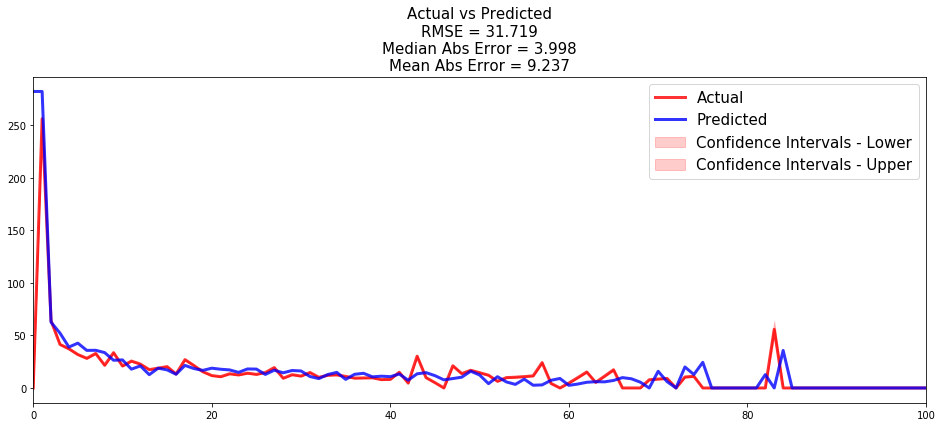

In [17]:
from pysurvival.utils.display import compare_to_actual
results = compare_to_actual(xst, X_test, T_test, E_test,
                            is_at_risk=False,
                            figure_size=(16, 6),
                            metrics=['rmse', 'mean', 'median'])

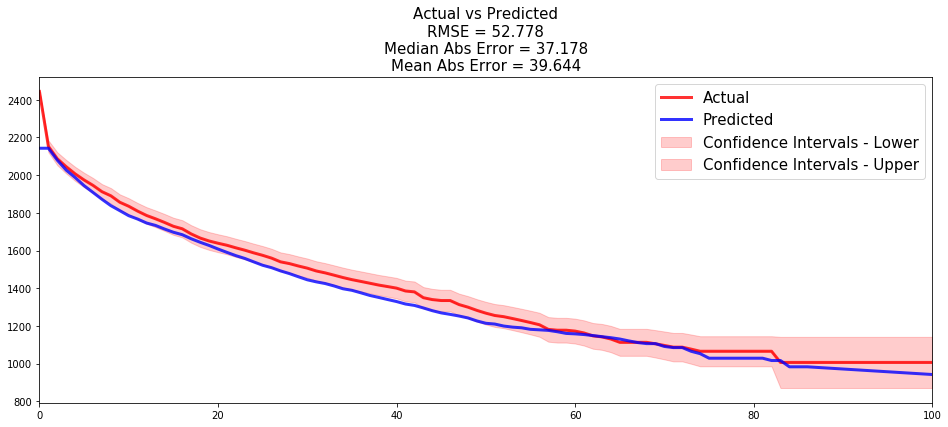

In [20]:
results = compare_to_actual(xst, X_test, T_test, E_test,
                            is_at_risk=True,
                            figure_size=(16, 6),
                            metrics=['rmse', 'mean', 'median'])

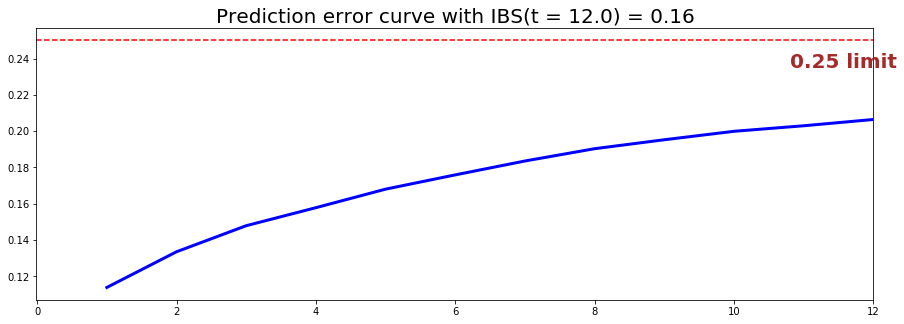

IBS: 0.160


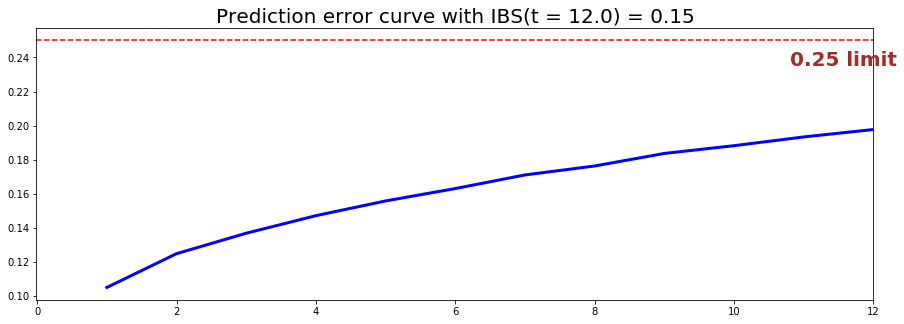

IBS: 0.149


In [18]:
# Print IBS
print('IBS: {:.3f}'.format(integrated_brier_score(xst, X_train, T_train, E_train, t_max=12, figure_size=(15, 5))))
print('IBS: {:.3f}'.format(integrated_brier_score(xst, X_test, T_test, E_test, t_max=12, figure_size=(15, 5))))

In [25]:
# Computing variables importance
xst.variable_importance_table.head(20)

,feature,importance,pct_importance
0,customer_state_GO,2.235831,0.215063
1,customer_state_PR,2.032525,0.195507
2,customer_state_CE,1.735949,0.166980
3,customer_state_MG,1.164705,0.112032
4,customer_state_PI,1.025978,0.098688
5,customer_state_SC,0.864383,0.083144
6,customer_state_MT,0.753418,0.072471
7,customer_state_PE,0.301417,0.028993
8,customer_state_SP,0.281955,0.027121
9,customer_state_AL,0.000000,0.000000


In [21]:
from pysurvival.utils.display import create_risk_groups

ValueError: The boundaries definitions [(0.0, 1.65), (1.65, 2.2), (2.2, 3.0)] do not match, the values of the risk scores.

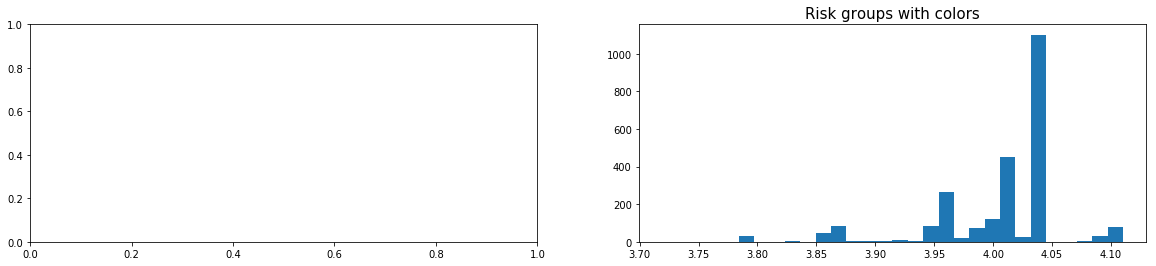

In [22]:
# Create risk groups
risk_groups = create_risk_groups(model=xst, X=X_test,
                                 use_log=True,
                                 num_bins=30,
                                 figure_size=(20, 4),
                                 low={'lower_bound': 0., 'upper_bound': 1.65, 'color': 'red'},
                                 medium={'lower_bound': 1.65, 'upper_bound': 2.2, 'color': 'green'},
                                 high={'lower_bound': 2.2, 'upper_bound': 3., 'color': 'blue'})